In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque
from skimage.metrics import structural_similarity as ssim

In [2]:
# GLOBAL SETUPS
TEMPLATE_BANK_SIZE = 5
NCC_THRESHOLD = 0.5
template_bank = []

##
## Utility Functions

In [3]:
def read_video_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        print("Cannot read video.")
        cap.release()
        return None, None, None
    return cap, frame, ret

def load_template(initial_template_path, frame_gray):
    template = cv2.imread(initial_template_path, cv2.IMREAD_GRAYSCALE)
    if template is None:
        print("Template image not found or failed to load.")
        return None

    coords = cv2.findNonZero(template)
    if coords is None:
        print("No non-zero pixels in template.")
        return None

    x, y, w, h = cv2.boundingRect(coords)
    cropped_template = frame_gray[y:y+h, x:x+w]
    return cropped_template, (x, y, w, h)

def setup_video_writer(output_path, frame_shape, fps):
    frame_h, frame_w = frame_shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_w, frame_h))
    print(f"💾 Output video will be saved to: {output_path}")
    return out



##
## Template Matching + Bank

In [4]:
def get_patch(frame_gray, template_coords, padding=10):
    x, y, w, h = template_coords
    x_start = max(0, x - padding)
    y_start = max(0, y - padding)
    x_end = min(frame_gray.shape[1], x + w + padding)
    y_end = min(frame_gray.shape[0], y + h + padding)

    patch = frame_gray[y_start:y_end, x_start:x_end]
    patch_loc = (x_start, y_start)  # top-left of patch

    return patch, patch_loc

def display_patch(patch, frame_idx, padding):
    plt.figure(figsize=(4, 4))
    plt.imshow(patch, cmap='gray')
    plt.title(f"Patch (Frame {frame_idx}, Padding {padding})")
    plt.axis('off')
    plt.show()

def find_best_match(search_patch):
    global template_bank
    
    best_score = -1
    best_box = None
    boxes = []
    scores = []

    for template in template_bank:
        if search_patch.shape[0] < template.shape[0] or search_patch.shape[1] < template.shape[1]:
            continue  # Skip if template is larger than the search patch

        result = cv2.matchTemplate(search_patch, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        if max_val > best_score:
            best_score = max_val
            best_box = (*max_loc, template.shape[1], template.shape[0])  # (x, y, w, h)

        boxes.append((*max_loc, template.shape[1], template.shape[0]))
        scores.append(max_val)

    if best_box is None:
        best_box = (0, 0, 0, 0)

    return boxes, scores, best_score


def update_template_from_box(frame_gray, box):
    x, y, w, h = box
    new_template = frame_gray[y:y+h, x:x+w]
    coords = cv2.findNonZero(new_template)
    if coords is not None:
        x_, y_, w_, h_ = cv2.boundingRect(coords)
        return new_template[y_:y_+h_, x_:x_+w_]
    return new_template

def add_to_template_bank(patch):
    global template_bank
    
    template_bank.append(patch)
    if len(template_bank) > TEMPLATE_BANK_SIZE:
        template_bank.pop(0)

def apply_nms(boxes, scores, threshold, nms_thresh):
    if not boxes:
        return []

    indices = cv2.dnn.NMSBoxes(boxes, scores, threshold, nms_thresh)
    if len(indices) == 0:
        return []

    # Flatten indices to list of integers
    return [i[0] if isinstance(i, (list, np.ndarray)) else i for i in indices]

#================================================#
#======= FOR TEMPLATE BANK VISUALIZATION ========#
#================================================#

def get_template_index(template, template_bank):
    for i, t in enumerate(template_bank):
        if np.array_equal(t, template):
            return i
    return None  # Not found

def visualize_template_bank(template_bank, current_index=None, max_per_row=5, figsize=(15, 5), cmap='gray'):
    n = len(template_bank)
    if n == 0:
        print("⚠️ Template bank is empty.")
        return

    cols = min(n, max_per_row)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i, template in enumerate(template_bank):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(template, cmap=cmap)
        title = f"Template {i}"
        if i == current_index:
            # Highlight current template with red title and border
            title += " (Current)"
            ax.set_title(title, color='red')
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(2)
        else:
            ax.set_title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

##
## Main Tracking Function

In [5]:
def draw_tracking_box(frame, box):
    x, y, w, h = box
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)

def display_frame(frame, frame_idx):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
    plt.show()

def template_difference(template1, template2, threshold=0.2):
    if template1.shape != template2.shape:
        return True  # treat different shape as significantly different
    diff = np.mean((template1.astype(np.float32) - template2.astype(np.float32)) ** 2)
    norm = np.mean(template1.astype(np.float32) ** 2)
    nmse = diff / (norm + 1e-8)
    return nmse > threshold

def dynamic_template_matching(video_path, initial_template_path,
                              output_path="../../outputs/dttm_output.mp4",
                              threshold=0.7, nms_thresh=0.3):
    global template_bank
    
    padding = 10
    max_padding = 50
    min_padding = 5
    padding_step = 5
    
    cap, frame, ret = read_video_first_frame(video_path)
    if not ret:
        return

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    template, template_coords = load_template(initial_template_path, frame_gray)
    if template is None:
        cap.release()
        return

    add_to_template_bank(template)

    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    out = setup_video_writer(output_path, frame.shape, fps)

    frame_idx = 0

    while True:
        if frame_idx != 0:
            ret, frame = cap.read()
            if not ret:
                print("Video ended.")
                break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        search_patch, patch_loc = get_patch(frame_gray, template_coords, padding)

        '''
        FOR PATCH VISUALIZATION
        display_patch(search_patch, frame_idx, padding)
        '''
        boxes, scores, max_val = find_best_match(search_patch)
        
        print(f"[Frame {frame_idx}] Max match score: {max_val:.3f}")

        indices = apply_nms(boxes, scores, threshold, nms_thresh)
        if indices:
            padding = max(min_padding, padding - padding_step)
            best_idx = indices[0]
            best_box = boxes[best_idx]

            px, py = patch_loc
            global_box = (best_box[0] + px, best_box[1] + py, best_box[2], best_box[3])

            print(f"  ↪ Object tracked at {global_box}")
            draw_tracking_box(frame, global_box)

            new_template = update_template_from_box(frame_gray, global_box)
            if new_template is not None and template_difference(new_template, template, threshold=0.2):
                template = new_template
                template_coords = global_box
                add_to_template_bank(template)
                print("  ↪ Template updated and added to bank.\n")
            else:
                print("  ↪ Template not different enough, skipped.\n")
        else:
            padding = min(max_padding, padding + padding_step)
            print("  ⚠️ No match above threshold or NMS removed all boxes.\n")

        '''
        FOR TEMPLATE BANK VISUALIZATION
        current_template_index = get_template_index(template, template_bank)
        visualize_template_bank(template_bank, current_index=current_template_index)
        '''
        
        out.write(frame)
        display_frame(frame, frame_idx)
        frame_idx += 1

    cap.release()
    out.release()
    print("🎥 Video saved successfully.")

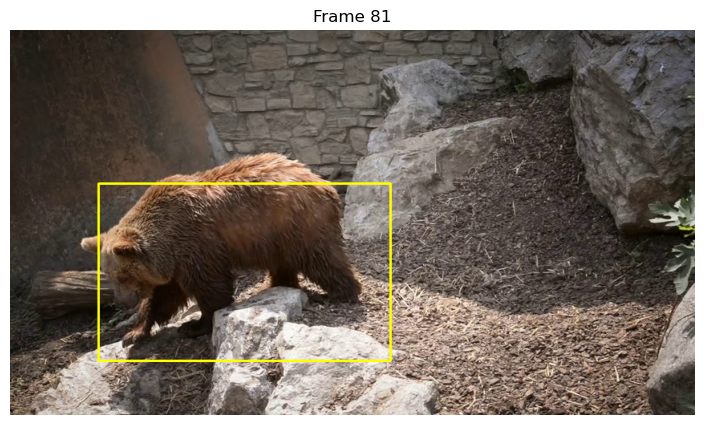

Video ended.
🎥 Video saved successfully.


In [10]:
'''
video_path = "../../videos/ficen_trimmed.mp4"
template_path = "../../outputs/segmented/ficen_trimmed_segmented.png"
'''
video_path = "../../data/DAVIS/videos/bear.mp4"
template_path = "../../outputs/segmented/bear_segmented.png"

output_path = "../../outputs/dttm_output.mp4"

dynamic_template_matching(
    video_path=video_path,
    initial_template_path=template_path,
    output_path=output_path,
    threshold=0.3,     # Matching confidence
    nms_thresh=0.3     # NMS IoU threshold
)